## Prédiction des émissions de CO2 et energie totale  pour anticipez les besoins en consommation de bâtiments
#### Auteur: SACKO Alseny

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import missingno as mno
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from category_encoders import TargetEncoder
from sklearn.feature_selection  import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### INPORTATION DES DONNEES

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [3]:
data_energy = pd.read_csv(r'C:\Users\pc\Documents\projet.3.O.C.Rnew\Donnees\dataSetEnergy.csv')

In [4]:
data_energy.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),NaturalGas(kBtu),TotalGHGEmissions
0,NonResidential,Hotel,DOWNTOWN,1927,12,88434,0,88434.0,60.0,7456910.0,2003882.00,1276453.0,249.98
1,NonResidential,Hotel,DOWNTOWN,1996,11,103566,15064,83880.0,61.0,8664479.0,0.00,5145082.0,295.86
2,NonResidential,Hotel,DOWNTOWN,1969,41,956110,196718,756493.0,43.0,73937112.0,21566554.00,1493800.0,2089.28
3,NonResidential,Hotel,DOWNTOWN,1926,10,61320,0,61320.0,56.0,6946800.5,2214446.25,1811213.0,286.43
4,NonResidential,Hotel,DOWNTOWN,1980,18,175580,62000,123445.0,75.0,14656503.0,0.00,8803998.0,505.01


In [5]:
(data_energy.isna().sum()/data_energy.shape[0]).sort_values(ascending=True)*100

BuildingType                  0.000000
PrimaryPropertyType           0.000000
Neighborhood                  0.000000
YearBuilt                     0.000000
NumberofFloors                0.000000
PropertyGFATotal              0.000000
PropertyGFAParking            0.000000
SiteEnergyUseWN(kBtu)         0.177725
SteamUse(kBtu)                0.266588
NaturalGas(kBtu)              0.266588
TotalGHGEmissions             0.266588
LargestPropertyUseTypeGFA     0.592417
ENERGYSTARScore              24.970379
dtype: float64

### Feature engineering
Ici, nous allons créer deux variabes, la première est "UtiliseVapeur", c-à-d, si le bâtiment utilise le gaz à vapeur 1 sinon 0, la deuxième variable est "UtiliseNturalGas", c-à-d, si le bâtiment utilise le gaz naturel ou non (1, 0)

In [6]:
def consoenergy(data_energy):
    if data_energy["SteamUse(kBtu)"] >=1:
        return 1
    else:
        return 0

In [7]:
data_energy["UtiliseVapeur"] = data_energy.apply(consoenergy, axis=1)

In [8]:
def consogaz(data_energy):
    if data_energy["NaturalGas(kBtu)"] > 1:
        return 1
    else:
        return 0   

In [10]:
data_energy["UtiliseNturalGas"] = data_energy.apply(consogaz, axis=1)

In [11]:
data_energy.drop(["SteamUse(kBtu)", "NaturalGas(kBtu)"], axis=1, inplace = True)

In [12]:
df_energy=data_energy.copy()

In [14]:
df_energy.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,UtiliseVapeur,UtiliseNturalGas
0,NonResidential,Hotel,DOWNTOWN,1927,12,88434,0,88434.0,60.0,7456910.0,249.98,1,1
1,NonResidential,Hotel,DOWNTOWN,1996,11,103566,15064,83880.0,61.0,8664479.0,295.86,0,1
2,NonResidential,Hotel,DOWNTOWN,1969,41,956110,196718,756493.0,43.0,73937112.0,2089.28,1,1
3,NonResidential,Hotel,DOWNTOWN,1926,10,61320,0,61320.0,56.0,6946800.5,286.43,1,1
4,NonResidential,Hotel,DOWNTOWN,1980,18,175580,62000,123445.0,75.0,14656503.0,505.01,0,1


### TrainTest - Encoage - Nettoyage

In [15]:
trainset, testset = train_test_split(df_energy, test_size = 0.2 , random_state=10)

### Encodage des variables qualitatives

In [16]:
def encodage(df_energy):
    encoder_Neighborhood = TargetEncoder()
    encoder_PrimaryPropertyType = TargetEncoder()
    encoder_BuildingType = TargetEncoder()

    encoder_Neighborhood.fit(trainset["Neighborhood"], trainset["TotalGHGEmissions"])
    trainset["Neighborhood"]= encoder_Neighborhood.transform(trainset["Neighborhood"])
    testset["Neighborhood"]= encoder_Neighborhood.transform(testset["Neighborhood"])

    encoder_PrimaryPropertyType.fit(trainset["PrimaryPropertyType"], trainset["TotalGHGEmissions"])
    trainset["PrimaryPropertyType"]= encoder_PrimaryPropertyType.transform(trainset["PrimaryPropertyType"])
    testset["PrimaryPropertyType"]= encoder_PrimaryPropertyType.transform(testset["PrimaryPropertyType"])

    encoder_BuildingType.fit(trainset["BuildingType"], trainset["TotalGHGEmissions"])
    trainset["BuildingType"]= encoder_BuildingType.transform(trainset["BuildingType"])
    testset["BuildingType"]= encoder_BuildingType.transform(testset["BuildingType"])
    return df_energy

### Suppression des valeurs abérantes

In [17]:
from statistics import*
from numpy import nan

In [18]:
median = float(df_energy['NumberofFloors'].median())
df_energy['NumberofFloors'] = np.where(df_energy['NumberofFloors']  > median, median, df_energy['NumberofFloors'] )

median = float(df_energy['PropertyGFATotal'].median())
df_energy['PropertyGFATotal'] = np.where(df_energy['PropertyGFATotal'] > median, median, df_energy['PropertyGFATotal'] )

median = float(df_energy['LargestPropertyUseTypeGFA'].median())
df_energy['LargestPropertyUseTypeGFA'] = np.where(df_energy['LargestPropertyUseTypeGFA']  > median, median, df_energy['LargestPropertyUseTypeGFA'] )

median = float(df_energy['LargestPropertyUseTypeGFA'].median())
df_energy['LargestPropertyUseTypeGFA'] = np.where(df_energy['LargestPropertyUseTypeGFA']  > median, median, df_energy['LargestPropertyUseTypeGFA'] )

median = float(df_energy['SiteEnergyUseWN(kBtu)'].median())
df_energy['SiteEnergyUseWN(kBtu)'] = np.where(df_energy['SiteEnergyUseWN(kBtu)']  > median, median, df_energy['SiteEnergyUseWN(kBtu)'] )

median = float(df_energy['TotalGHGEmissions'].median())
df_energy['TotalGHGEmissions'] = np.where(df_energy['TotalGHGEmissions']  > median, median, df_energy['TotalGHGEmissions'] )

In [19]:
##Suppression des lignes où quantité totale d'émissions de gaz à effet de serre,y compris le dioxyde de carbone <= à zéros
def removed(df_energy):
    df_energy = df_energy.drop(index=df_energy[df_energy['TotalGHGEmissions']<=0].index)
##Suppression des modalités(Multifamily LR (1-4),Multifamily MR (5-9), Multifamily HR (10+)) pour la colonne BuildingType
    df_energy = df_energy.drop(index=df_energy[df_energy['BuildingType']=='Multifamily HR (10+)'].index)
    df_energy = df_energy.drop(index=df_energy[df_energy['BuildingType']=='Multifamily MR (5-9)'].index)
    df_energy = df_energy.drop(index=df_energy[df_energy['BuildingType']=='Multifamily LR (1-4)'].index)
    
    return df_energy

In [20]:
#df_energy = removed(df_energy)

### Imputation des valeurs manquantes

In [21]:
def imputation(df_energy):
    return df_energy.dropna(axis=0)

In [22]:
#def imputation(df_energy):
    #return df_energy.fillna(-999)

## Application des différentes fonctions de praitement à l'ensemble de données

In [23]:
def preprocessing(df_energy):
    df_energy = encodage(df_energy)
    df_energy = removed(df_energy)
    df_energy = imputation(df_energy)
    X = df_energy.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)", "ENERGYSTARScore"], axis = 1)
    y = df_energy["TotalGHGEmissions"]
    return X, y

In [24]:
X_train, y_train =preprocessing(trainset)

In [25]:
X_train.shape

(1998, 10)

In [26]:
y_train.shape

(1998,)

In [27]:
X_test, y_test =preprocessing(testset)

In [28]:
X_test.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseTypeGFA,UtiliseVapeur,UtiliseNturalGas
3337,179.537884,416.920979,149.189280,2014,4,126823,41539,88157.0,0,1
689,179.537884,42.171513,90.381407,1914,2,33589,0,33589.0,0,1
1033,179.537884,199.816593,73.551834,1962,1,25159,0,25883.0,0,1
814,28.773796,27.005570,197.408623,1925,3,23989,0,23989.0,0,0
2592,66.167740,63.860771,149.189280,2013,7,88450,0,225337.0,0,1


In [29]:
y_test.shape

(523,)

## Modèles de Machine Learning sans "ENERGYSTARScore"

### Instanciation du modèle

In [30]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [31]:
model = make_pipeline(SelectKBest(k=7, score_func=f_regression), RandomForestRegressor(random_state = 100))

In [32]:
model

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function f_regression at 0x000002C5C4A4B160>)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=100))])

## Conception et dianostique des modèle avec learning_curve

In [33]:
from sklearn.model_selection import learning_curve

In [34]:
def evaluation(model):
    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test.values.ravel(), predictions)
   #Erreur quadratique moyenne (MSE)
    mse = mean_squared_error(y_test.values.ravel(), predictions)
   #Scores-R au carré
    r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
    print('Mean Absolute Error:', round(mae, 2))
    print('Mean Squared Error:', round(mse, 2))
    print('R-squared scores:', round(r2, 2))
    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                        cv=10, scoring = 'neg_mean_squared_error',
                                        train_sizes = np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, -train_score.mean(axis = 1), label='train_score')
    plt.plot(N, -val_score.mean(axis = 1), label='val_score')
   # plt.ylabel('MSE', fontsize = 14)
   # plt.xlabel('Training set size', fontsize = 14)
    plt.legend()

Mean Absolute Error: 40.04
Mean Squared Error: 7401.67
R-squared scores: 0.62


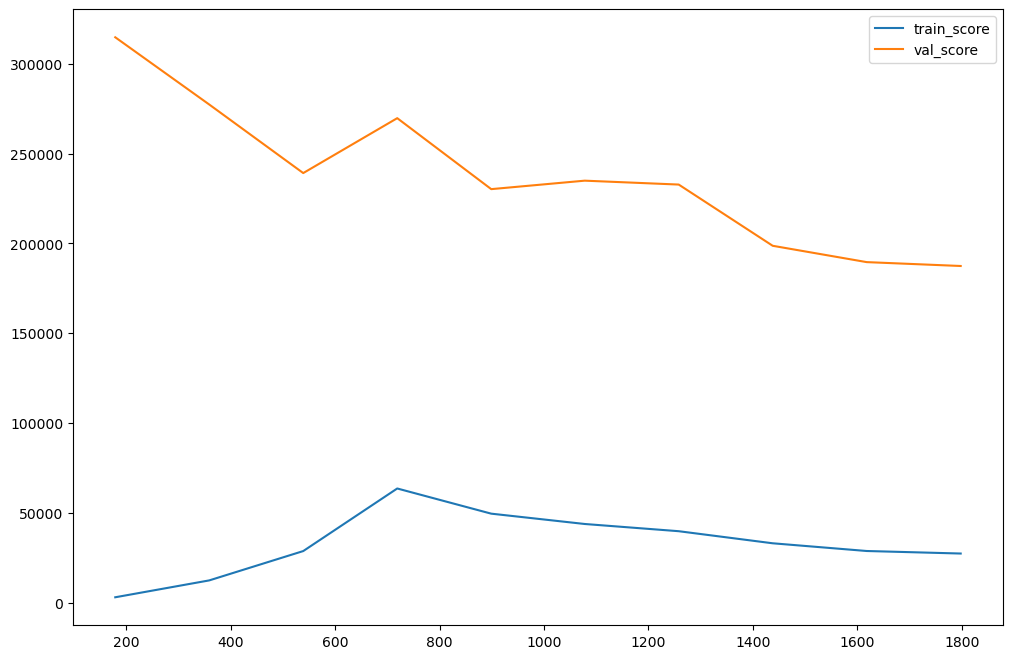

In [35]:
evaluation(model)

## Pipeline d'évaluationdes modèles

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
preprocessor = make_pipeline(SelectKBest(k=7, score_func=f_regression))

In [38]:
ArbreRegression = make_pipeline(preprocessor, DecisionTreeRegressor(random_state = 100))
Random_Forest = make_pipeline(preprocessor, RandomForestRegressor(random_state = 100))
AdaBosst = make_pipeline(preprocessor, AdaBoostRegressor(random_state=100))
Regression_Linear = make_pipeline(preprocessor, StandardScaler(), LinearRegression())
Dummy_Regressor = make_pipeline(preprocessor, DummyRegressor())

In [39]:
list_models = {"ArbreRegression\n": ArbreRegression,
               "Random_Forest \n": Random_Forest, 
               "AdaBosst\n": AdaBosst,
               "Regression_Linear\n": Regression_Linear, 
               "Dummy_Regressor\n": Dummy_Regressor
              }



 ArbreRegression

Mean Absolute Error: 51.19
Mean Squared Error: 10995.65
R-squared scores: 0.44


 Random_Forest 

Mean Absolute Error: 40.04
Mean Squared Error: 7401.67
R-squared scores: 0.62


 AdaBosst

Mean Absolute Error: 144.47
Mean Squared Error: 41778.76
R-squared scores: -1.14


 Regression_Linear

Mean Absolute Error: 139.32
Mean Squared Error: 37680.3
R-squared scores: -0.93


 Dummy_Regressor

Mean Absolute Error: 102.67
Mean Squared Error: 21220.5
R-squared scores: -0.09


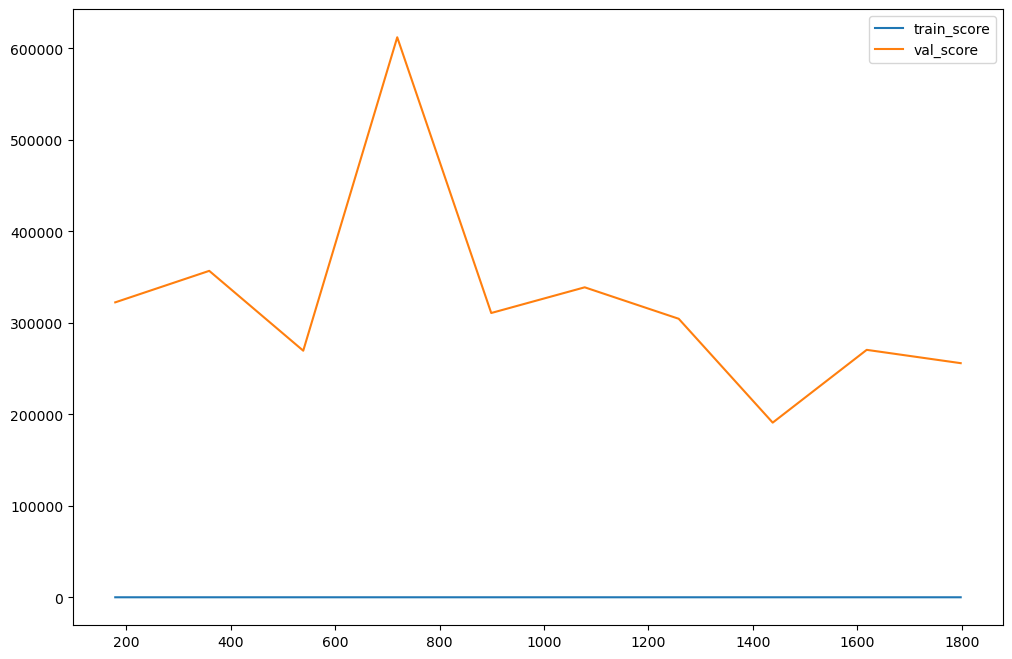

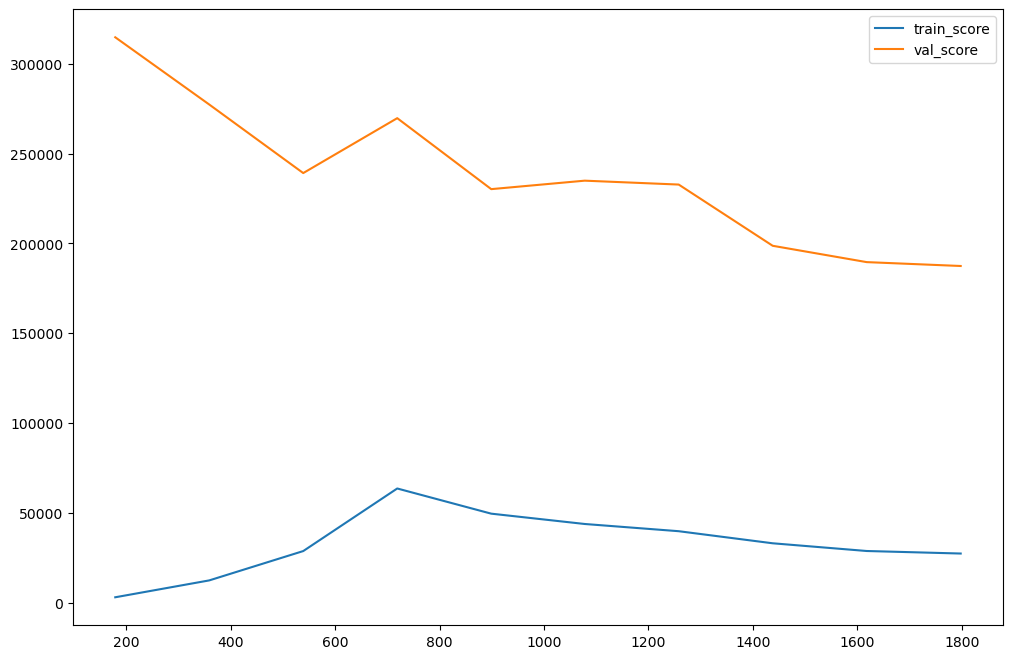

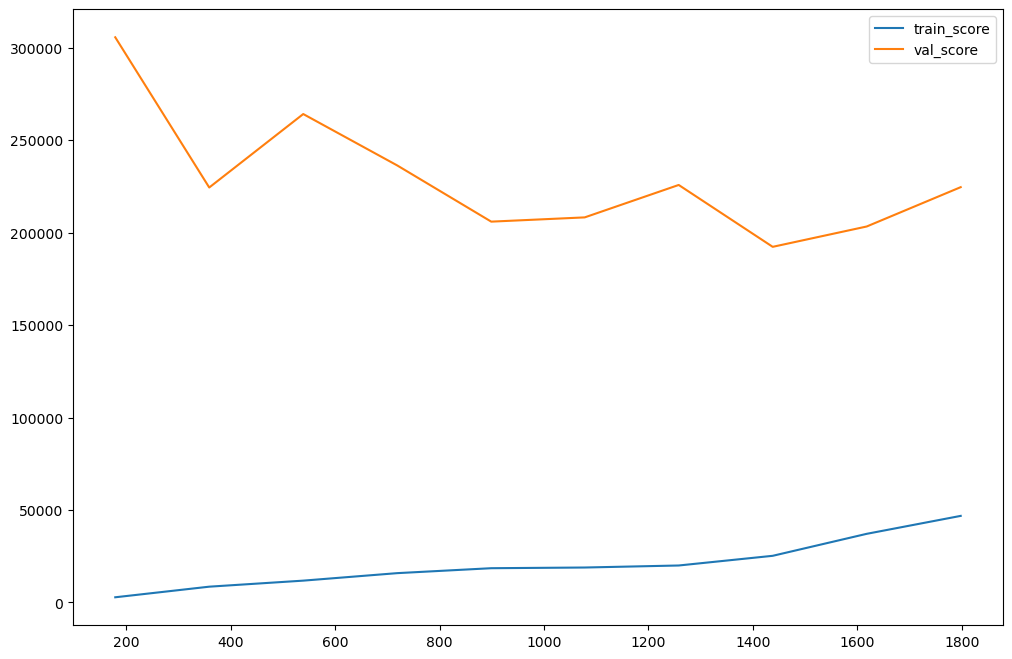

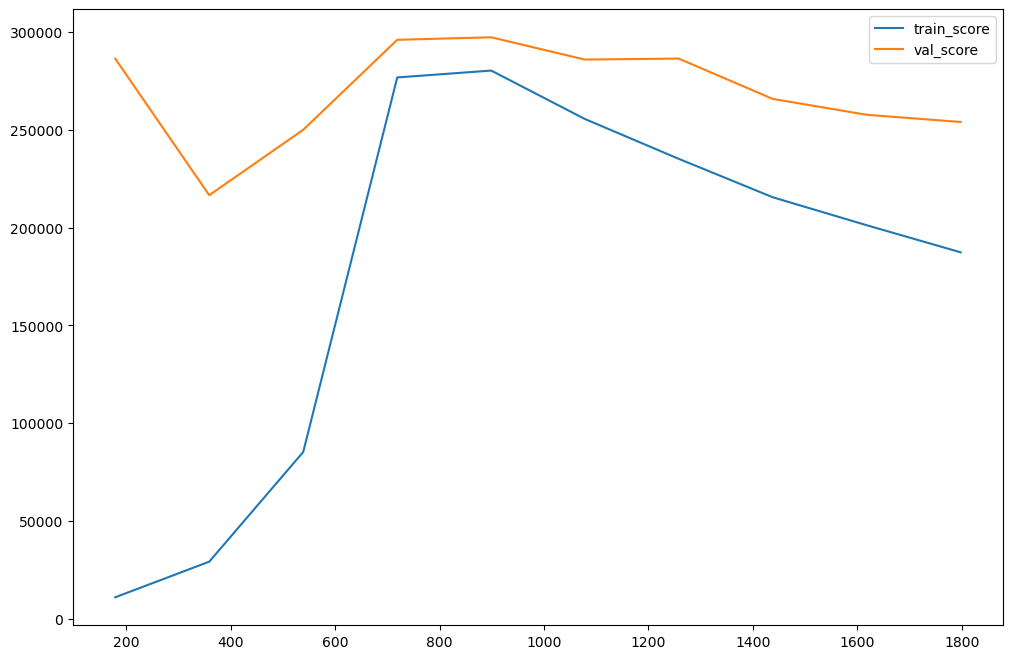

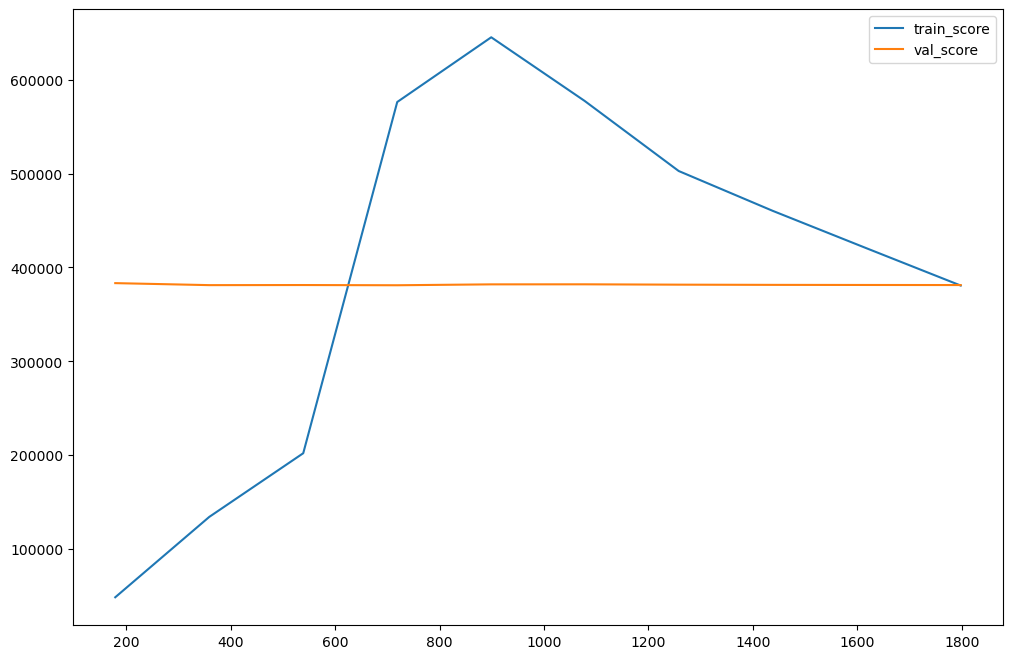

In [40]:
for name, value in list_models.items():
    print('\n\n',name)
    evaluation(value)

## Optimisation 
### Recherche des Hyperparametres optimaux par la GridSearchCV

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

In [42]:
Random_Forest 

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('selectkbest',
                                  SelectKBest(k=7,
                                              score_func=<function f_regression at 0x000002C5C4A4B160>))])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=100))])

In [43]:
param_grid = {
    'randomforestregressor__max_depth': [30, 40, 50],
    'randomforestregressor__max_features': [2, 6, 7],
    'randomforestregressor__n_estimators': [80, 200, 300]
}

In [44]:
# Instantiate the grid search model
grid_search = GridSearchCV(Random_Forest, param_grid, scoring = 'r2', cv = 3, n_jobs = -1, verbose = 2)

In [45]:
def evaluation(grid_search):
    grid_search.fit(X_train, y_train.values.ravel())
    predictions = grid_search.predict(X_test)
    mae = mean_absolute_error(y_test.values.ravel(), predictions)
   #Erreur quadratique moyenne (MSE)
    mse = mean_squared_error(y_test.values.ravel(), predictions)
   #Scores-R au carré
    r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
    print('Mean Absolute Error:', round(mae, 2))
    print('Mean Squared Error:', round(mse, 2))
    print('R-squared scores:', round(r2, 2))
    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                        cv=10, scoring = 'neg_mean_squared_error',
                                        train_sizes = np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, -train_score.mean(axis = 1), label='train_score')
    plt.plot(N, -val_score.mean(axis = 1), label='val_score')
   # plt.ylabel('MSE', fontsize = 14)
   # plt.xlabel('Training set size', fontsize = 14)
    plt.legend()

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mean Absolute Error: 39.17
Mean Squared Error: 6542.85
R-squared scores: 0.66


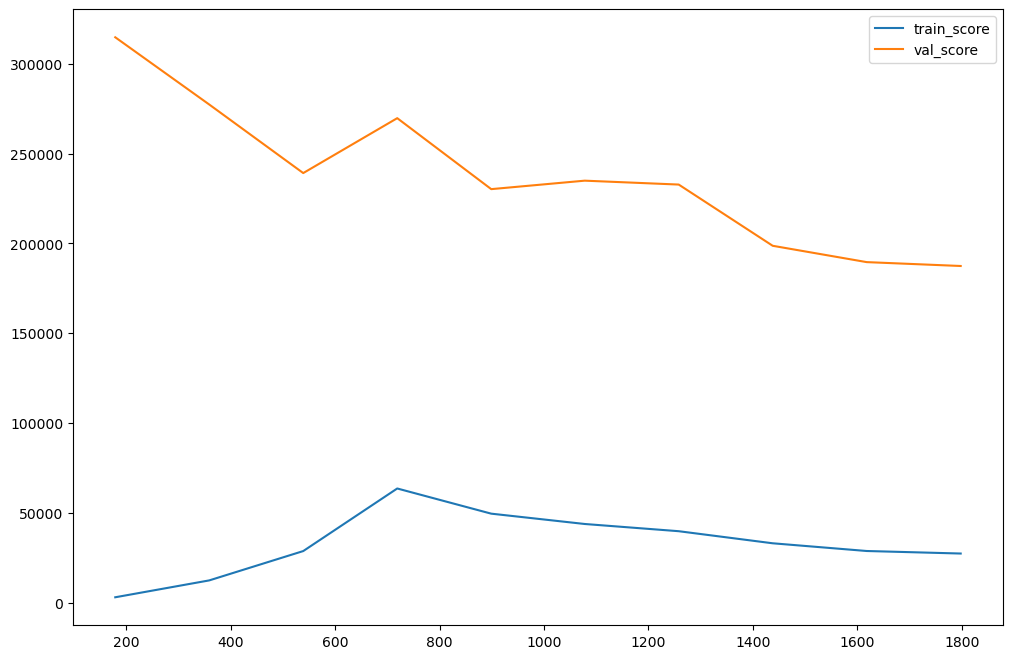

In [46]:
evaluation(grid_search)

In [61]:
#pd.DataFrame(grid_search.best_estimator_._final_estimator.feature_importances_).plot.bar()

## Modèles avec la variable "ENERGYSTARScore"

In [48]:
def preprocessing(df_energy):
    df_energy = encodage(df_energy)
    df_energy = removed(df_energy)
    df_energy = imputation(df_energy)
    X = df_energy.drop(["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"], axis = 1)
    y = df_energy["TotalGHGEmissions"]
    return X, y

In [49]:
X_train, y_train =preprocessing(trainset)

In [50]:
X_train.shape

(1998, 11)

In [51]:
y_train.shape

(1998,)

In [52]:
X_test, y_test =preprocessing(trainset)

In [53]:
X_test.shape

(1998, 11)

In [54]:
y_test.shape

(1998,)

In [55]:
model = make_pipeline(SelectKBest(k=7, score_func=f_regression), RandomForestRegressor(random_state = 100))

In [56]:
model

Pipeline(steps=[('selectkbest',
                 SelectKBest(k=7,
                             score_func=<function f_regression at 0x000002C5C4A4B160>)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=100))])

In [57]:
def evaluation(model):
    model.fit(X_train, y_train.values.ravel())
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test.values.ravel(), predictions)
   #Erreur quadratique moyenne (MSE)
    mse = mean_squared_error(y_test.values.ravel(), predictions)
   #Scores-R au carré
    r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
    print('Mean Absolute Error:', round(mae, 2))
    print('Mean Squared Error:', round(mse, 2))
    print('R-squared scores:', round(r2, 2))
    N, train_score, val_score = learning_curve(model, X_train, y_train, 
                                        cv=10, scoring = 'neg_mean_squared_error',
                                        train_sizes = np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, -train_score.mean(axis = 1), label='train_score')
    plt.plot(N, -val_score.mean(axis = 1), label='val_score')
   # plt.ylabel('MSE', fontsize = 14)
   # plt.xlabel('Training set size', fontsize = 14)
    plt.legend()

### Instanciation des modèles

In [58]:
ArbreRegression = make_pipeline(preprocessor, DecisionTreeRegressor(random_state = 100))
Random_Forest = make_pipeline(preprocessor, RandomForestRegressor(random_state = 100))
AdaBosst = make_pipeline(preprocessor, AdaBoostRegressor(random_state=100))
Regression_Linear = make_pipeline(preprocessor, StandardScaler(), LinearRegression())
Dummy_Regressor = make_pipeline(preprocessor, DummyRegressor())

In [59]:
list_models = {"ArbreRegression\n": ArbreRegression,
               "Random_Forest \n": Random_Forest, 
               "AdaBosst\n": AdaBosst,
               "Regression_Linear\n": Regression_Linear, 
               "Dummy_Regressor\n": Dummy_Regressor
              }



 ArbreRegression

Mean Absolute Error: 0.05
Mean Squared Error: 2.02
R-squared scores: 1.0


 Random_Forest 

Mean Absolute Error: 26.49
Mean Squared Error: 27953.92
R-squared scores: 0.93


 AdaBosst

Mean Absolute Error: 143.66
Mean Squared Error: 39758.43
R-squared scores: 0.9


 Regression_Linear

Mean Absolute Error: 170.88
Mean Squared Error: 190389.26
R-squared scores: 0.5


 Dummy_Regressor

Mean Absolute Error: 143.53
Mean Squared Error: 380697.76
R-squared scores: 0.0


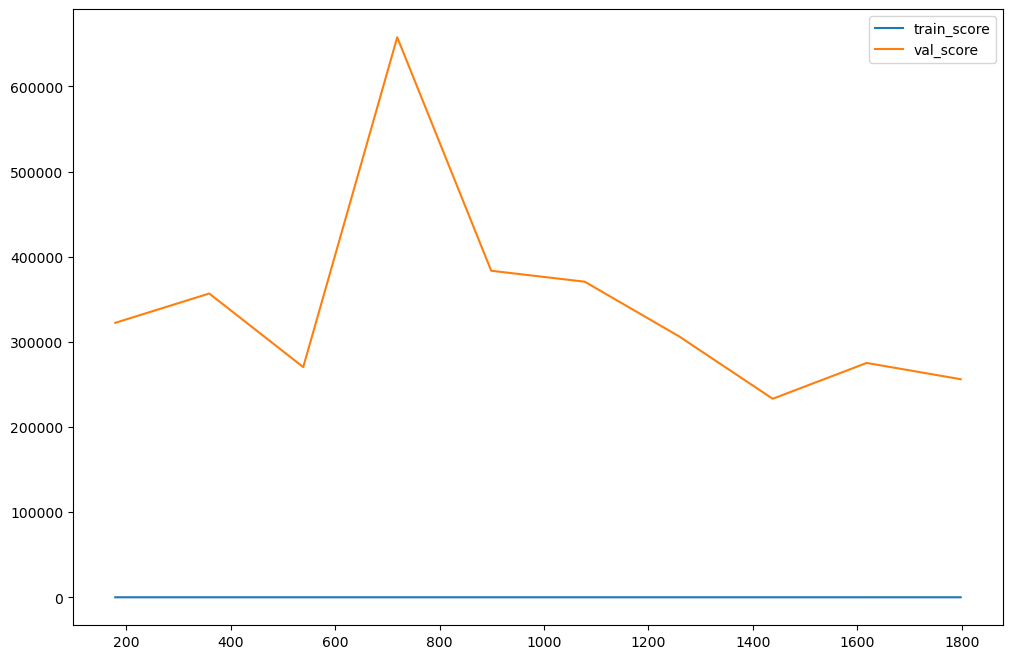

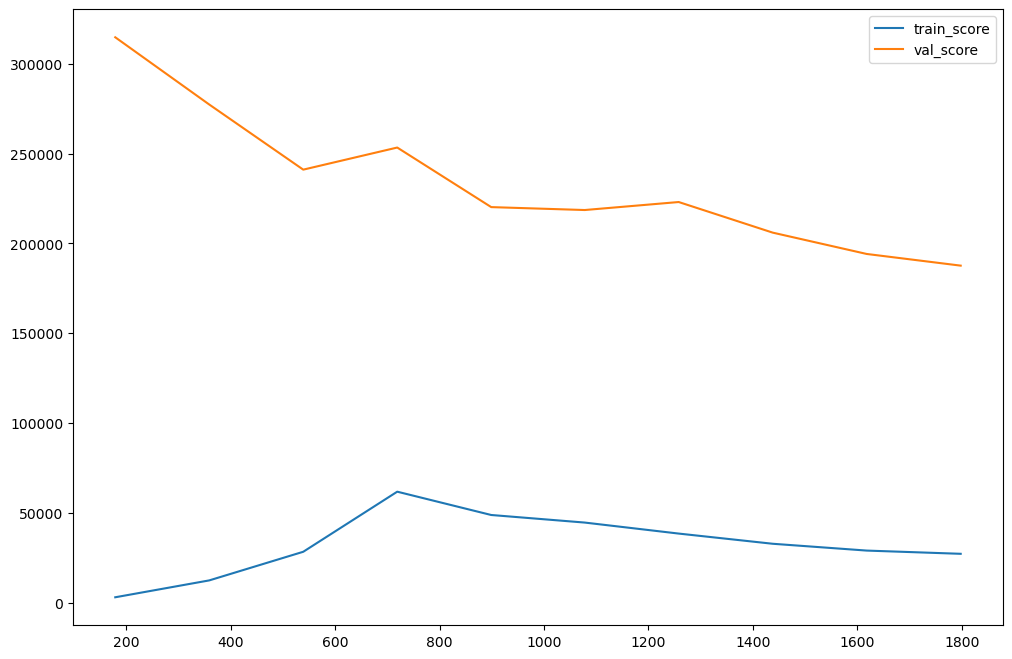

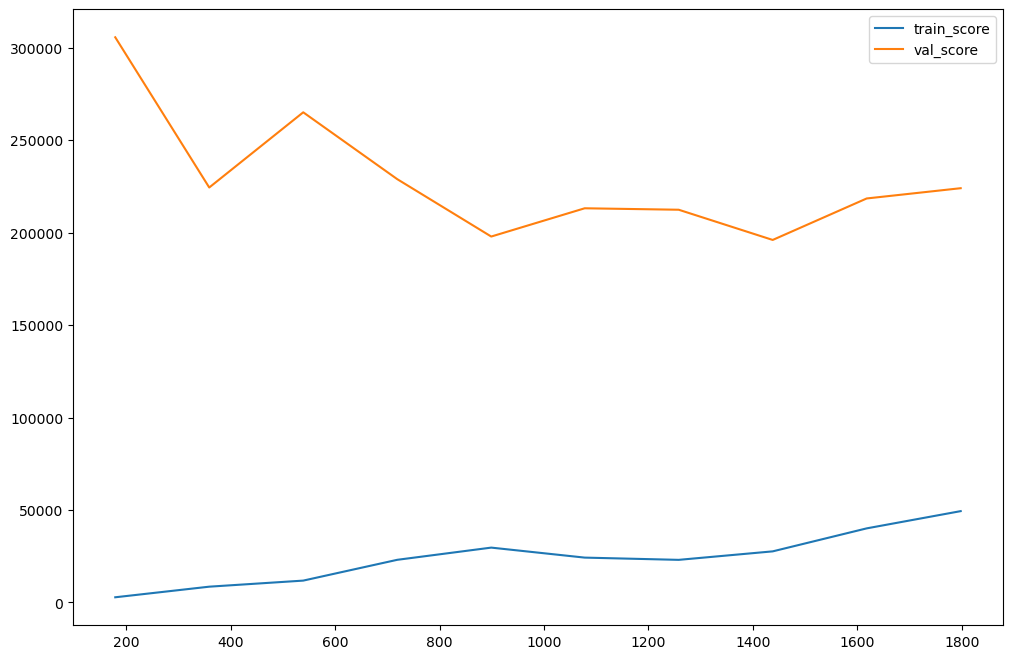

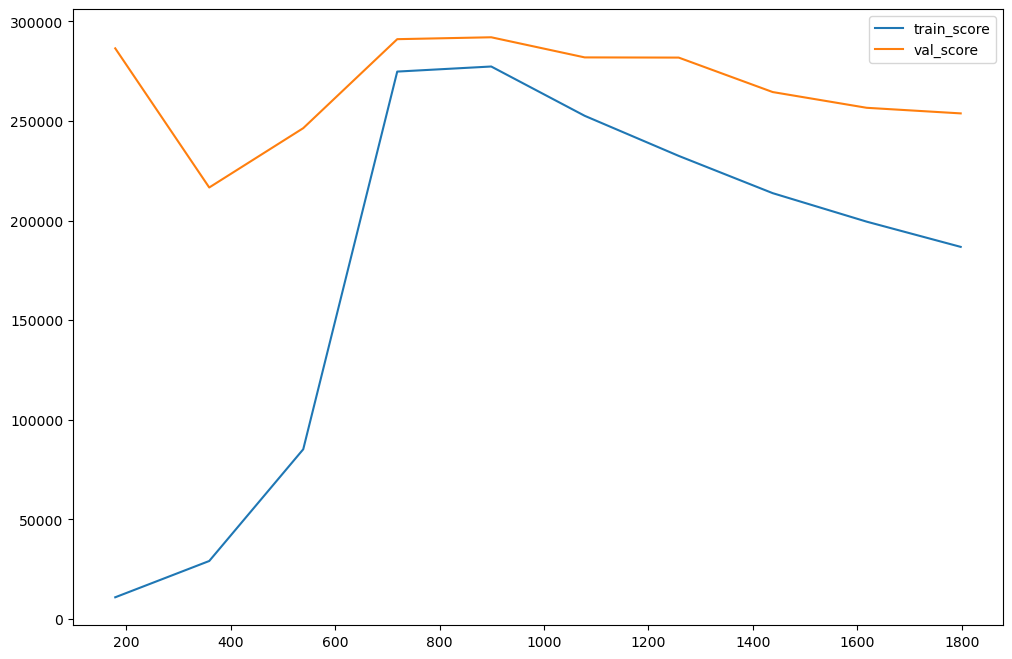

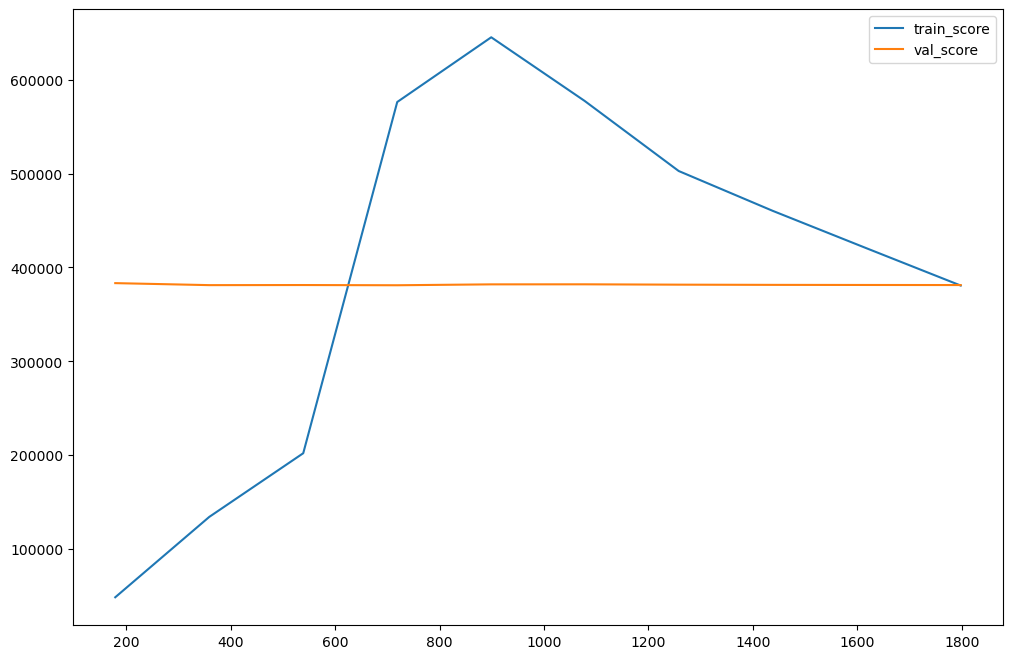

In [60]:
for name, value in list_models.items():
    print('\n\n',name)
    evaluation(value)

### 